<a href="https://colab.research.google.com/github/kebabee/autoencoder-memory/blob/main/associative_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Associative memory in autoencoders

The Hopfield network (and especially the dense associative memory) provided associative memory in the neural network. Such a network learns the patterns themselves and does not learn the noise, yet is able to reproduce patterns with different types of noise or with only part of the pattern. Is this the only architecture at which it is not necessary to learn noise to correctly reproduce patterns?

## Case study

I will try to implement associative memory in autoencoder. The idea is simple:
* A simple autoencoder learns to reconstruct 1000 MNIST digits without any noise, pixel clipping, etc.
* After learning, in the autoencoder input I put digits with noise, halved, etc.
* I count the difference between noisy and original and between restored and original.

If the reconstructed digits are more similar to the originals than the noisy ones, it can be concluded that somehow the associative memory has been successfully implemented.

## First autoencoder

We have 5 layers: 784 neurons - 256 - 64 - 256 - 784. The autoencoder learns 1000 digits (100 for each one) with different number of epochs (from 1 to 201 every 10). The test set is different variations of "spoiled" digits. We have consecutively:
* 10% random pixels set to 0.5 (original [0,255] is scaled to [0,1])
* 30% random pixels set to 0.5
* 50% random pixels set to 0.5
* first 10% pixels is set to 0.5
* first 30% pixels is set to 0.5
* first 50% pixels is set to 0.5

0.5 occurs less frequently in the original digits than either 0 or 1. I would like as little information as possible about the digit itself to come out of the noise.

Loading MNIST and libraries:


In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

selected_digits = []
for digit in range(10):
  idx = np.where(y_train == digit)[0][:100]
  selected_digits.append(x_train[idx])

selected_digits = np.array(selected_digits).reshape(-1, 28, 28)
selected_digits = selected_digits.astype('float32') / 255.0 # rescale to [0,1]
selected_digits = selected_digits.reshape(-1, 784) # to vector

preparing spoiled digits:

In [57]:
def add_noise(images, noise_factor):
    noisy_images = images.copy()
    n_pixels = int(noise_factor * images.shape[1])
    for img in noisy_images:
        noise_idx = np.random.choice(images.shape[1], n_pixels, replace=False)
        img[noise_idx] = 0.5
    return noisy_images

def cut_pixels(images, noise_factor):
    noisy_images = images.copy()
    n_pixels = int(noise_factor * images.shape[1])
    for img in noisy_images:
        noise_idx = np.arange(n_pixels)
        img[noise_idx] = 0.5
    return noisy_images

rand10_digits = add_noise(selected_digits, 0.1)
rand30_digits = add_noise(selected_digits, 0.3)
rand50_digits = add_noise(selected_digits, 0.5)
first10_digits = cut_pixels(selected_digits, 0.1)
first30_digits = cut_pixels(selected_digits, 0.3)
first50_digits = cut_pixels(selected_digits, 0.5)

defining simple autoencoder:

In [58]:
input_img = Input(shape=(784,))
encoded = Dense(256, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

### Sample:
Autoecnoder learned digits for 100 epochs, it is tested for two selected test datasets.


Epoch 1/100
10/10 [==============================] - 1s 20ms/step - loss: 0.5883
Epoch 2/100
10/10 [==============================] - 0s 22ms/step - loss: 0.3269
Epoch 3/100
10/10 [==============================] - 0s 24ms/step - loss: 0.2782
Epoch 4/100
10/10 [==============================] - 0s 24ms/step - loss: 0.2616
Epoch 5/100
10/10 [==============================] - 0s 25ms/step - loss: 0.2499
Epoch 6/100
10/10 [==============================] - 0s 28ms/step - loss: 0.2375
Epoch 7/100
10/10 [==============================] - 0s 26ms/step - loss: 0.2228
Epoch 8/100
10/10 [==============================] - 0s 24ms/step - loss: 0.2061
Epoch 9/100
10/10 [==============================] - 0s 25ms/step - loss: 0.1919
Epoch 10/100
10/10 [==============================] - 0s 27ms/step - loss: 0.1817
Epoch 11/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1748
Epoch 12/100
10/10 [==============================] - 0s 19ms/step - loss: 0.1683
Epoch 13/100
10/10 [=====

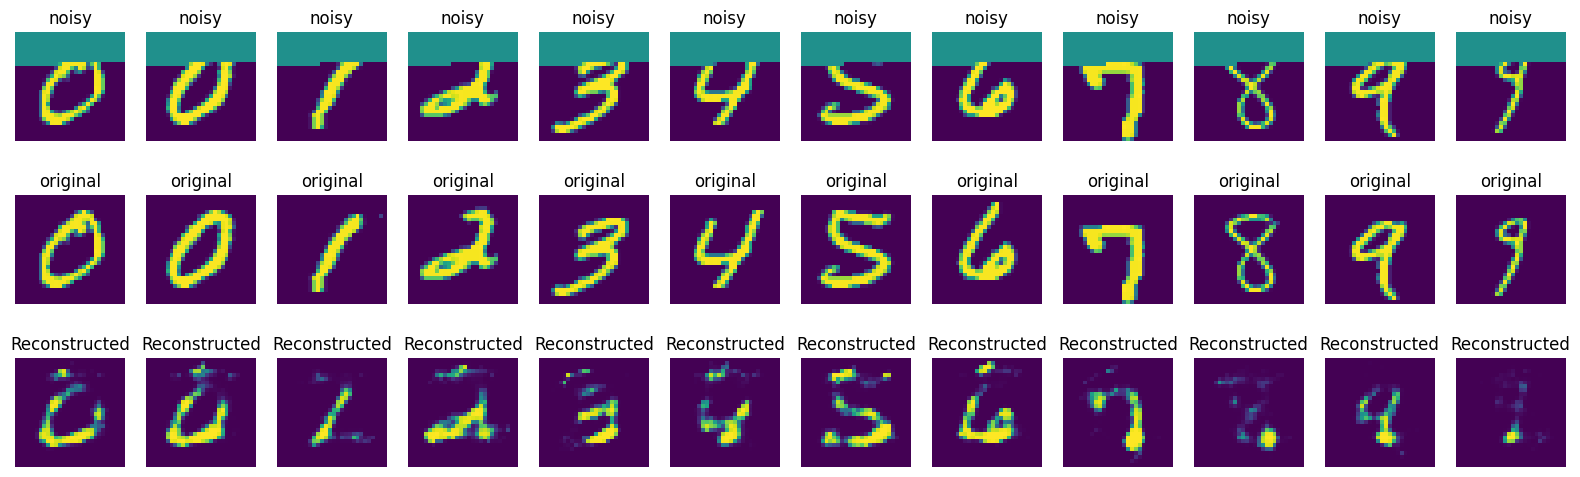

Mean difference between original and first 30% noised: 0.1451353281736374
Mean difference between original and reconstructed: 0.09115283191204071


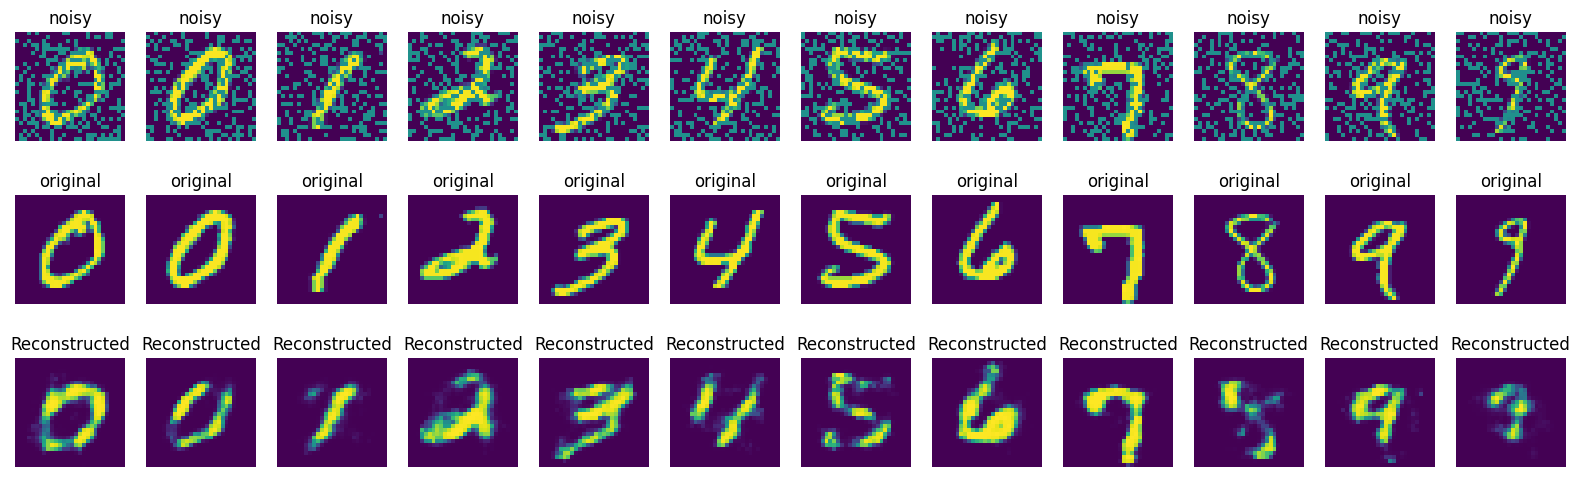

Mean difference between original and random 30% noised: 0.14163602888584137
Mean difference between original and reconstructed: 0.07095123082399368


In [59]:
autoencoder.fit(selected_digits, selected_digits, epochs=100, batch_size=100, shuffle=True)
#autoencoder.save('simple_autoencoder.h5')

def plot_images(original, noisy, reconstructed, n):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy[90*i].reshape(28, 28))
        plt.title("noisy")
        plt.axis('off')

        # Display noisy
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(original[90*i].reshape(28, 28))
        plt.title("original")
        plt.axis('off')

        # Display reconstruction
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed[90*i].reshape(28, 28))
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

decoded_imgs_1 = autoencoder.predict(first30_digits)
decoded_imgs_2 = autoencoder.predict(rand30_digits)

plot_images(selected_digits, first30_digits, decoded_imgs_1, n=12)

mean_diff_noisy_original_1 = np.mean(np.abs(selected_digits - first30_digits))
mean_diff_decoded_original_1 = np.mean(np.abs(selected_digits - decoded_imgs_1))

print(f"Mean difference between original and first 30% noised: {mean_diff_noisy_original_1}")
print(f"Mean difference between original and reconstructed: {mean_diff_decoded_original_1}")


plot_images(selected_digits, rand30_digits, decoded_imgs_2, n=12)

mean_diff_noisy_original_2 = np.mean(np.abs(selected_digits - rand30_digits))
mean_diff_decoded_original_2 = np.mean(np.abs(selected_digits - decoded_imgs_2))

print(f"Mean difference between original and random 30% noised: {mean_diff_noisy_original_2}")
print(f"Mean difference between original and reconstructed: {mean_diff_decoded_original_2}")

Just to check, how this autoencoder works with "predicting" originals?

32/32 [==============================] - 0s 3ms/step


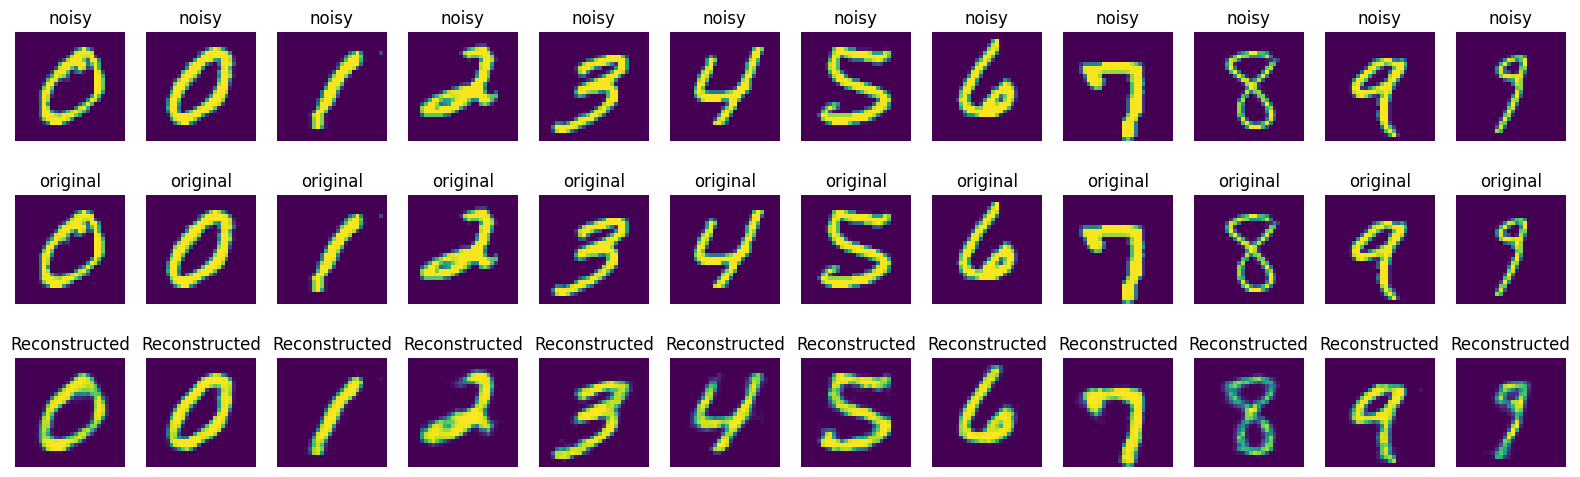

Mean difference between original and original xD: 0.0
Mean difference between original and reconstructed: 0.02386518009006977


In [60]:
decoded_imgs_3 = autoencoder.predict(selected_digits)

plot_images(selected_digits, selected_digits, decoded_imgs_3, n=12)

mean_diff_noisy_original_3 = np.mean(np.abs(selected_digits - selected_digits)) #duh
mean_diff_decoded_original_3 = np.mean(np.abs(selected_digits - decoded_imgs_3))

print(f"Mean difference between original and original xD: {mean_diff_noisy_original_3}")
print(f"Mean difference between original and reconstructed: {mean_diff_decoded_original_3}")

The digits returned by the autoencoder turned out to be slightly more similar to the originals than the noisy digits. I will run multiple autoencoders with different test datasets and epochs to investigate this relation in more details.

## Main experiment

I will record "factor of differences" as:
$$a=\frac{\text{Mean difference between original and decoded}}{\text{Mean difference between original and noised}}$$
with independent $a$ for every test dataset.

When $a<1$ it means that the reconstructed digits are more similar to the originals than the noised ones. This is situation that I am looking for. In addition I will check how the quality of "originals to originals" prediction changes with number of epochs.

In [67]:
a_first10 = []
a_first30 = []
a_first50 = []
a_rand10 = []
a_rand30 = []
a_rand50 = []
originals_diffs = []

mean_diff_first10_original = np.mean(np.abs(selected_digits - first10_digits))
mean_diff_first30_original = np.mean(np.abs(selected_digits - first30_digits))
mean_diff_first50_original = np.mean(np.abs(selected_digits - first50_digits))
mean_diff_rand10_original = np.mean(np.abs(selected_digits - rand10_digits))
mean_diff_rand30_original = np.mean(np.abs(selected_digits - rand30_digits))
mean_diff_rand50_original = np.mean(np.abs(selected_digits - rand50_digits))

epochs = np.linspace(1, 501, 51)
#epochs = [10,20,30]
for e in epochs:
  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
  autoencoder.fit(selected_digits, selected_digits, epochs=int(e), batch_size=10, shuffle=True, verbose=0)

  decoded_imgs = autoencoder.predict(first10_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  a_first10.append(mean_diff_decoded_original/mean_diff_first10_original)

  decoded_imgs = autoencoder.predict(first30_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  a_first30.append(mean_diff_decoded_original/mean_diff_first30_original)

  decoded_imgs = autoencoder.predict(first50_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  a_first50.append(mean_diff_decoded_original/mean_diff_first50_original)

  decoded_imgs = autoencoder.predict(rand10_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  a_rand10.append(mean_diff_decoded_original/mean_diff_rand10_original)

  decoded_imgs = autoencoder.predict(rand30_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  a_rand30.append(mean_diff_decoded_original/mean_diff_rand30_original)

  decoded_imgs = autoencoder.predict(rand50_digits)
  mean_diff_decoded_original = np.mean(np.abs(selected_digits - decoded_imgs))
  a_rand50.append(mean_diff_decoded_original/mean_diff_rand50_original)

  decoded_imgs = autoencoder.predict(selected_digits)
  originals_diffs.append(np.mean(np.abs(selected_digits - decoded_imgs)))

print(a_first10)
print(a_first30)
print(a_first50)
print(a_rand10)
print(a_rand30)
print(a_rand50)
print(originals_diffs)


32/32 [==============================] - 0s 4ms/step


KeyboardInterrupt: 

In [ ]:
# prompt: 6 subplots with matplotlib

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))

# Subplot 1: First 10% pixels cut
plt.subplot(2, 3, 1)
plt.plot(epochs, a_first10)
plt.xlabel('Epochs')
plt.ylabel('Factor of differences')
plt.title('First 10% pixels cut')

# Subplot 2: First 30% pixels cut
plt.subplot(2, 3, 2)
plt.plot(epochs, a_first30)
plt.xlabel('Epochs')
plt.ylabel('Factor of differences')
plt.title('First 30% pixels cut')

# Subplot 3: First 50% pixels cut
plt.subplot(2, 3, 3)
plt.plot(epochs, a_first50)
plt.xlabel('Epochs')
plt.ylabel('Factor of differences')
plt.title('First 50% pixels cut')

# Subplot 4: 10% random pixels set to 0.5
plt.subplot(2, 3, 4)
plt.plot(epochs, a_rand10)
plt.xlabel('Epochs')
plt.ylabel('Factor of differences')
plt.title('10% random pixels set to 0.5')

# Subplot 5: 30% random pixels set to 0.5
plt.subplot(2, 3, 5)
plt.plot(epochs, a_rand30)
plt.xlabel('Epochs')
plt.ylabel('Factor of differences')
plt.title('30% random pixels set to 0.5')

# Subplot 6: 50% random pixels set to 0.5
plt.subplot(2, 3, 6)
plt.plot(epochs, a_rand50)
plt.xlabel('Epochs')
plt.ylabel('Factor of differences')
plt.title('50% random pixels set to 0.5')

plt.show()
